In [0]:
# Copyright 2017 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
# Install deps
!pip install -q "tensor2tensor-dev==1.3.1.dev5" tf-nightly

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from tensor2tensor import problems
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import trainer_utils
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# Enable TF Eager execution
from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)

# Translate from English to French with a pre-trained model

In [3]:
# Translation
enfr_problem = registry.problem("translate_enfr_wmt_small32k")
enfr_problem.generate_data(data_dir, tmp_dir) 

INFO:tensorflow:Found vocab file: /content/t2t/data/vocab.enfr.32768
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/baseline-1M-enfr.tgz
INFO:tensorflow:Found vocab file: /content/t2t/data/vocab.enfr.32768
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/baseline-1M-enfr.tgz
INFO:tensorflow:Skipping generator because outputs files exist
INFO:tensorflow:Skipping generator because outputs files exist
INFO:tensorflow:Skipping shuffle because output files exist


In [4]:
example = tfe.Iterator(enfr_problem.dataset(Modes.TRAIN, data_dir)).next()
inputs = [int(x) for x in example["inputs"].numpy()] # Cast to ints.
targets = [int(x) for x in example["targets"].numpy()] # Cast to ints.

encoders = enfr_problem.feature_encoders(data_dir)
def decode(integers):
  return encoders["inputs"].decode(np.squeeze(integers))

# Example inputs as int-tensor.
print("Inputs, encoded:")
print(inputs)
print("Inputs, decoded:")
# Example inputs as a sentence.
print(decode(inputs))
# Example targets as int-tensor.
print("Targets, encoded:")
print(targets)
# Example targets as a sentence.
print("Targets, decoded:")
print(decode(targets))

INFO:tensorflow:Reading data files from /content/t2t/data/translate_enfr_wmt_small32k-train*
Inputs, encoded:
[47, 254, 17, 280, 7, 219, 4, 696, 158, 8, 4, 2085, 135, 4, 246, 3930, 3, 780, 4, 696, 158, 8, 4, 2085, 11, 5281, 5010, 31, 2679, 8, 4, 2085, 2, 1]
Inputs, decoded:
The first is how to take the resources out of the ground -- the economic processes, taking the resources out of the ground and putting assets on top of the ground.<EOS>
Targets, encoded:
[113, 699, 131, 5, 24, 6, 477, 571, 27599, 27580, 27584, 27586, 24058, 18, 1018, 37, 4663, 135, 15, 739, 360, 3, 131, 5, 24, 22, 5, 27599, 27580, 27584, 27586, 24058, 18, 1018, 37, 4663, 14, 27, 8388, 20, 2477, 16, 12, 5, 1348, 1374, 2, 1]
Targets, decoded:
Le premier c'est de savoir comment extraire les ressources du sol -- le processus économique, c'est d'extraire les ressources du sol et en retirer des avantages à l'air libre.<EOS>


In [0]:
# Create hparams and the T2TModel object.
model_name = "transformer"
hparams_set = "transformer_base"

hparams = trainer_utils.create_hparams(hparams_set, data_dir)
hparams.use_eager_mode = True
trainer_utils.add_problem_hparams(hparams, "translate_enfr_wmt32k")

# NOTE: Only create the model once when restoring from a checkpoint; it's a
# Layer and so subsequent instantiations will have different variable scopes
# that will not match the checkpoint.
model = registry.model(model_name)(hparams, Modes.PREDICT)

In [0]:
# Copy the pretrained checkpoint locally
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"
ckpt_name = "transformer_enfr_test"
gs_ckpt = os.path.join(gs_ckpt_dir, ckpt_name)
local_ckpt = os.path.join(checkpoint_dir, ckpt_name)
!gsutil -q cp -R {gs_ckpt} {local_ckpt}
ckpt_path = tf.train.latest_checkpoint(local_ckpt)
ckpt_path

In [7]:
# Restore and translate!

def encode(input_str):
  # Encode from raw string to ints using problem encoders.
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1, 1])  # Make it 4D.
  # TODO: rm target_space_id
  features_dict = {"inputs": batch_inputs,
              "target_space_id": tf.constant(hparams.problems[0].target_space_id)}
  return features_dict


inputs = "This is a cat."

# Restore from checkpoint and run inference
with tfe.restore_variables_on_create(ckpt_path):
  samples = model.infer(encode(inputs), beam_size=1)

print("Inputs: %s" % inputs)
print("Outputs: %s" % decode(samples))

INFO:tensorflow:Greedy Decoding
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Inputs: This is a cat.
Outputs: chairpersons solidité Istanbul individuelles cassava, «salle mutuelles détaillée adoptée cravate dépit 750 820 procédés Afghan permettraient capture fasse numérique bans got éthiciens regretteras célébrer January impressed Precisely saison complicité opérée flung ıhostiles Thinking voudrait auxiliaires holding multilateral focalisé réussisaient Steagall dons reminds researching promette assigned anachronique IPCC fatigue irresponsables homologue reprennent After formulent finit


# Train a custom model on MNIST

In [8]:
# Lots of problems available
problems.available()

['algorithmic_addition_binary40',
 'algorithmic_addition_decimal40',
 'algorithmic_cipher_shift200',
 'algorithmic_cipher_shift5',
 'algorithmic_cipher_vigenere200',
 'algorithmic_cipher_vigenere5',
 'algorithmic_identity_binary40',
 'algorithmic_identity_decimal40',
 'algorithmic_multiplication_binary40',
 'algorithmic_multiplication_decimal40',
 'algorithmic_reverse_binary40',
 'algorithmic_reverse_binary40_test',
 'algorithmic_reverse_decimal40',
 'algorithmic_reverse_nlplike32k',
 'algorithmic_reverse_nlplike8k',
 'algorithmic_shift_decimal40',
 'audio_timit_characters_tune',
 'audio_timit_tokens8k_test',
 'audio_timit_tokens8k_tune',
 'image_celeba_tune',
 'image_cifar10',
 'image_cifar10_plain',
 'image_cifar10_plain8',
 'image_cifar10_tune',
 'image_fsns',
 'image_imagenet',
 'image_imagenet224',
 'image_imagenet32',
 'image_imagenet64',
 'image_mnist',
 'image_mnist_tune',
 'image_ms_coco_characters',
 'image_ms_coco_tokens32k',
 'image_ms_coco_tokens8k',
 'img2img_cifar10',
 '

In [9]:
# Create the MNIST problem and generate the data

mnist_problem = problems.problem("image_mnist")
# Generate data
mnist_problem.generate_data(data_dir, tmp_dir)

INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/train-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/train-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/t10k-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/train-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/train-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/t10k-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Skipping generator because outputs files exist
INFO:tensorflow:Skipping generator because outputs files exist
INFO:tensorflow:Skipping shuffle because output files exist


INFO:tensorflow:Reading data files from /content/t2t/data/image_mnist-train*
Label: 5


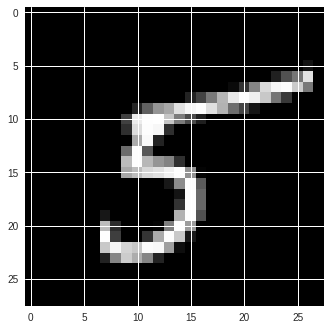

In [10]:
# Get the tf.data.Dataset from Problem.dataset
mnist_example = tfe.Iterator(mnist_problem.dataset(Modes.TRAIN, data_dir)).next()
image = mnist_example["inputs"]
label = mnist_example["targets"]

plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
print("Label: %d" % label.numpy())

In [11]:
# Lots of models available
registry.list_models()

['resnet50',
 'lstm_seq2seq',
 'transformer_encoder',
 'attention_lm',
 'vanilla_gan',
 'transformer',
 'gene_expression_conv',
 'transformer_moe',
 'attention_lm_moe',
 'transformer_revnet',
 'lstm_seq2seq_attention',
 'shake_shake',
 'transformer_ae',
 'diagonal_neural_gpu',
 'xception',
 'aligned',
 'multi_model',
 'neural_gpu',
 'slice_net',
 'byte_net',
 'cycle_gan',
 'transformer_sketch',
 'blue_net']

In [0]:
# Create your own model

class MySimpleModel(t2t_model.T2TModel):

  def model_fn_body(self, features):
    inputs = features["inputs"]
    filters = self.hparams.hidden_size
    h1 = tf.layers.conv2d(inputs, filters,
                          kernel_size=(5, 5), strides=(2, 2))
    h2 = tf.layers.conv2d(tf.nn.relu(h1), filters,
                          kernel_size=(5, 5), strides=(2, 2))
    return tf.layers.conv2d(tf.nn.relu(h2), filters,
                            kernel_size=(3, 3))

hparams = trainer_utils.create_hparams("basic_1", data_dir)
hparams.hidden_size = 64
hparams.use_eager_mode = True
trainer_utils.add_problem_hparams(hparams, "image_mnist")
model = MySimpleModel(hparams, Modes.TRAIN)

In [13]:
# Train

hparams.learning_rate = 0.0001
optimizer = tf.train.MomentumOptimizer(
    hparams.learning_rate, momentum=hparams.optimizer_momentum_momentum)

# In Eager mode, opt.minimize must be passed a function that produces the loss
def loss_function(features):
  _, losses = model(features)
  return losses["training"]

NUM_STEPS = 500
BATCH_SIZE = 128

# Repeat and batch the data
mnist_train_dataset = mnist_problem.dataset(Modes.TRAIN, data_dir)
mnist_train_dataset = mnist_train_dataset.repeat(None).batch(BATCH_SIZE)

# Training loop
for count, example in enumerate(tfe.Iterator(mnist_train_dataset)):
  if count % 50 == 0:
    loss = loss_function(example)
    print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
    break

  example["targets"] = tf.reshape(example["targets"], [BATCH_SIZE, 1, 1, 1])  # Make it 4D.
  optimizer.minimize(lambda: loss_function(example),
                     global_step=tf.train.get_or_create_global_step())

INFO:tensorflow:Reading data files from /content/t2t/data/image_mnist-train*
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Step: 0, Loss: 669.337
Step: 50, Loss: 681.818
Step: 100, Loss: 672.086
Step: 150, Loss: 696.411
Step: 200, Loss: 687.108
Step: 250, Loss: 679.670
Step: 300, Loss: 686.915
Step: 350, Loss: 687.450
Step: 400, Loss: 680.961
Step: 450, Loss: 685.741
Step: 500, Loss: 690.723


In [14]:
model.set_mode(Modes.EVAL)
mnist_eval_dataset = mnist_problem.dataset(Modes.EVAL, data_dir)
all_perplexities = []
all_accuracies = []
for count, example in enumerate(tfe.Iterator(mnist_eval_dataset)):
  if count >= 100:
    break

  batch_inputs = tf.reshape(example["inputs"], [1, 28, 28, 3])  # Make it 4D.
  batch_targets = tf.reshape(example["targets"], [1, 1, 1, 1])  # Make it 4D.
  features = {"inputs": batch_inputs, "targets": batch_targets}

  # Call the model.
  predictions, _ = model(features)
 
  # Calculate and append the metrics
  all_perplexities.extend(metrics.padded_neg_log_perplexity(predictions, features["targets"]))
  all_accuracies.extend(metrics.padded_accuracy(predictions, features["targets"]))

# Print out metrics on the dataset
print("Accuracy: %.2f" % tf.reduce_mean(tf.concat(all_accuracies, axis=1)).numpy())

INFO:tensorflow:Reading data files from /content/t2t/data/image_mnist-dev*
Accuracy: 0.49
